In [1]:
import warnings
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from jaxtyping import Float
from scipy.spatial import KDTree
from tqdm import tqdm


df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_filtered.csv")
out = df.partition_by("probe")

In [2]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-15, 0, 0.1),
        min_cluster_size=200,
        min_samples=1,
    )

points_final = {k: transform_fn(v) for k, v in points.items()}


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 150/150 [04:21<00:00,  1.74s/it]


In [3]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [4]:
idx = 15
bbox = bboxes[idx]
sq1 = {k: filter_bounded(v, bbox) for k, v in points_final.items()}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn_sq, metrics_sq = align_patch(
        sq1,
        tilt_sweep_values=np.arange(-5, 5, 0.001),
        rotation_sweep_values=np.arange(-4, 4, 0.1),
        min_cluster_size=500,
        min_samples=10,
    )

sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

100%|██████████| 80/80 [00:05<00:00, 15.98it/s]


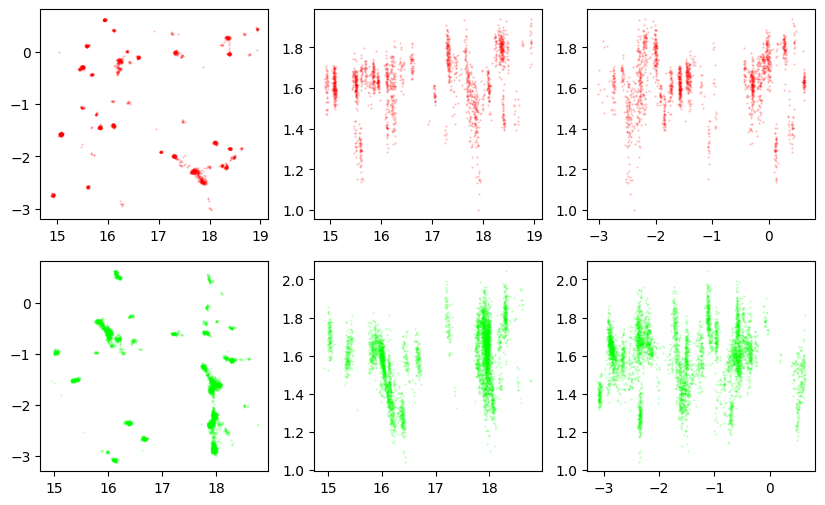

In [5]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            sq1_final[protein][:, ax1],
            sq1_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )


In [6]:
import pyvista as pv


p = pv.Plotter(notebook=True, window_size=(700, 700))
for protein in ("desmin", "actinin"):
    point_cloud = pv.PolyData(sq1_final[protein])
    point_cloud = point_cloud.project_points_to_plane(
        origin=[0, 0, 0], normal=[0, 0, 1]
    )
    p.add_mesh(
        point_cloud,
        color=COLOR_DICT[protein],
        style="points_gaussian",
        # emissive=True,
        point_size=5,
        opacity=0.2,
    )

p.set_background(color="black")
p.enable_parallel_projection()

p.view_xy()
axis = p.show_bounds(
    color="#888888",
    grid="back",
    bold=False,
    font_size=20,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
axis.x_axis_label_visibility = False
axis.y_axis_label_visibility = False
axis.z_axis_label_visibility = False
# p.camera.tight(padding=0.2)
p.show()
# p.save_graphic("../figures/fig_3/3a/overlay_2d.svg")

Widget(value='<iframe src="http://localhost:38277/index.html?ui=P_0x7f35e0f11880_0&reconnect=auto" class="pyvi…

In [7]:
import pyvista as pv


p = pv.Plotter(notebook=True, window_size=(700, 700))
for protein in ("desmin", "actinin"):
    point_cloud = pv.PolyData(sq1_final[protein])
    # point_cloud = point_cloud.project_points_to_plane(
    #     origin=[0, 0, 0], normal=[0, 0, 1]
    # )
    p.add_mesh(
        point_cloud,
        color=COLOR_DICT[protein],
        style="points_gaussian",
        # emissive=True,
        point_size=5,
        opacity=0.2,
    )

p.set_background(color="black")
# p.enable_parallel_projection()

# p.view_xy()
axis = p.show_bounds(
    color="#999999",
    grid="back",
    bold=False,
    font_size=20,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    # show_zaxis=False,
    xtitle="",
    ytitle="",
)
axis.x_axis_label_visibility = False
axis.y_axis_label_visibility = False
axis.z_axis_label_visibility = False
p.camera.azimuth = 200
p.camera.zoom(0.9)
# p.camera.tight(padding=0.5)
p.show()
# p.save_graphic("../figures/fig_3/3b/overlay_3d.svg")

Widget(value='<iframe src="http://localhost:38277/index.html?ui=P_0x7f361312ff80_1&reconnect=auto" class="pyvi…

In [6]:
def angular_ripley_H(
    points: Float[np.ndarray, "N 3"],
    r: float = 1.0,
    num_bins: int = 100,
    sides: Sequence[float] = [4.0, 4.0],
    edge_correction: bool = True,
):
    n_points = points.shape[0]
    sides = np.asarray(sides)
    vol = np.prod(sides)
    tree = KDTree(points)
    in_range_indices = tree.query_ball_tree(tree, r)

    bins = np.linspace(-np.pi, np.pi, num_bins)
    k_angular = np.zeros_like(bins, shape=(len(bins) - 1,))

    for i, (indices, pt) in enumerate(zip(in_range_indices, tqdm(points))):
        nn = points[[j for j in indices if j != i]]
        shift = np.abs(nn - pt)
        if edge_correction:
            vol_intersection = np.prod(sides - shift, axis=-1)
            k_per_point = np.ones(len(nn)) / vol_intersection
        else:
            k_per_point = np.ones(len(nn)) / vol

        angles = np.atan2(nn[:, 1] - pt[1], nn[:, 0] - pt[0])

        k_angular = (
            k_angular
            + np.histogram(angles, bins, weights=k_per_point, density=False)[0]
        )

    delta_angle = bins[1] - bins[0]
    lambda_sq_inv = (vol * vol) / (n_points * (n_points - 1))
    ripley_K = (2 * np.pi / delta_angle) * lambda_sq_inv * k_angular
    ripley_L = np.sqrt(ripley_K / np.pi)
    ripley_H = ripley_L - r

    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers, ripley_H

In [7]:
angular_h_dict = {k: angular_ripley_H(v[:, :2], 0.5) for k, v in sq1_final.items()}

100%|█████████▉| 4664/4665 [00:00<00:00, 7274.85it/s]


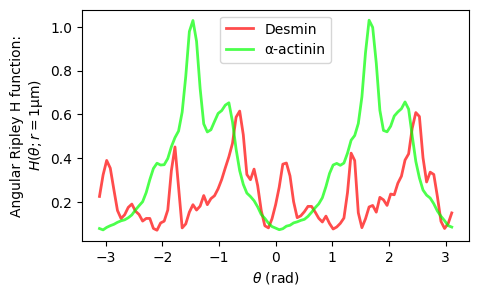

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

LABEL_DICT = {"desmin": "Desmin", "actinin": "α-actinin"}
COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}
for name, dist in angular_h_dict.items():
    ax.plot(
        *dist,
        alpha=0.7,
        linewidth=2.0,
        color=COLOR_DICT[name],
        label=LABEL_DICT[name],
    )

ax.set_xlabel(r"$\theta$" + " (rad)")
ax.set_ylabel("Angular Ripley H function:\n" + r"$H(\theta; r=1\text{μm})$")
# ax.set_xlim((-0.02, 0.52))
ax.legend()

In [9]:
ripley_H_rois = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    angular_ripleys = {k: angular_ripley_H(v[:, :2], 0.5) for k, v in sq1_final.items()}
    ripley_H_rois.append(angular_ripleys)

100%|██████████| 16/16 [03:15<00:00, 12.20s/it]


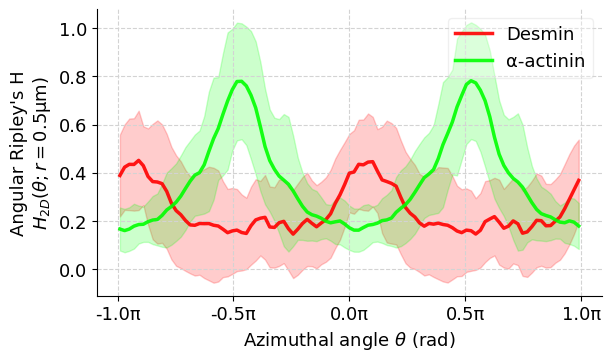

In [176]:
from desmin_reconstruction.plotting import line_and_bandplot


ripley_total = {k: [r[k][1] for r in ripley_H_rois] for k in ("desmin", "actinin")}
angles = ripley_H_rois[0]["desmin"][0]

plt.rc("font", size=13)
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5), constrained_layout=True)
for protein, h in ripley_total.items():
    ax = line_and_bandplot(
        ax,
        angles,
        np.mean(h, axis=0),
        np.std(h, axis=0),
        color=COLOR_DICT[protein],
        label=LABEL_DICT[protein],
        linewidth=2.5,
        alpha=0.9,
        alpha_band=0.2,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.set_xlabel("Azimuthal angle " + r"$\theta$" + " (rad)")
ax.set_ylabel("Angular Ripley's H\n" + r"$H_{2D}(\theta; r=0.5\text{μm})$")
ax.legend(loc="upper right", framealpha=0.3)
ax.set_xticks(
    [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
    ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
)
fig.savefig("../figures/fig_3/3a/angular_ripley_2d.svg", dpi=500)

In [40]:
def cartesian_to_spherical(
    xyz: Float[np.ndarray, "N 3"],
) -> tuple[Float[np.ndarray, " N"], Float[np.ndarray, " N"], Float[np.ndarray, " N"]]:
    r = np.sqrt(np.sum(xyz * xyz, axis=-1))
    theta = np.atan2(xyz[:, 1], xyz[:, 0])
    phi = np.acos(xyz[:, 2] / r)
    return r, theta, phi


def angular_ripley_H_3d(
    points: Float[np.ndarray, "N 3"],
    r: float = 1.0,
    num_bins: tuple[int, int] = (100, 100),
    sides: Sequence[float] = [4.0, 4.0, 1.0],
    edge_correction: bool = True,
):
    n_points = points.shape[0]
    sides = np.asarray(sides)
    volume = np.prod(sides)
    tree = KDTree(points)
    in_range_indices: list[list[int]] = tree.query_ball_tree(tree, r)

    bins_theta: Float[np.ndarray, " N_theta+1"] = np.linspace(
        -np.pi, np.pi, num_bins[0]
    )
    bins_phi: Float[np.ndarray, " N_phi+1"] = np.linspace(0, np.pi, num_bins[1])
    k_angular: Float[np.ndarray, "N_theta N_phi"] = np.zeros_like(
        bins_theta, shape=(num_bins[0] - 1, num_bins[1] - 1)
    )

    for i, point in enumerate(tqdm(points)):
        in_range_indices[i].remove(i)  # Remove self counting
        point_neighbors: Float[np.ndarray, "neighbors 3"] = points[in_range_indices[i]]
        displacements = point_neighbors - point

        if edge_correction:
            vol_intersection = np.prod(sides - np.abs(displacements), axis=-1)
            k_per_point: Float[np.ndarray, " neighbors"] = 1 / vol_intersection
        else:
            k_per_point: Float[np.ndarray, " neighbors"] = (
                np.ones(len(point_neighbors)) / volume
            )

        _, points_theta, points_phi = cartesian_to_spherical(displacements)

        k_angular = (
            k_angular
            + np.histogram2d(
                points_theta,
                points_phi,
                (bins_theta, bins_phi),
                weights=k_per_point,
                density=False,
            )[0]
        )

    lambda_sq_inv = (volume * volume) / (n_points * (n_points - 1))
    phi: Float[np.ndarray, " N_phi"] = (bins_phi[1:] + bins_phi[:-1]) / 2
    d_theta, d_phi = bins_theta[1] - bins_theta[0], bins_phi[1] - bins_phi[0]
    d_Omega: Float[np.ndarray, " N_phi"] = np.sin(phi) * d_theta * d_phi

    K_angular = (4 * np.pi / d_Omega) * lambda_sq_inv * k_angular
    L_angular = np.cbrt(3 * K_angular / (4 * np.pi))
    H_angular = L_angular - r

    return H_angular, (bins_theta, bins_phi)

In [46]:
ripley_H_rois_3d = []
for roi in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, roi) for k, v in points_final.items()}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        transform_fn_sq, _ = align_patch(
            sq1,
            tilt_sweep_values=np.arange(-5, 5, 0.001),
            rotation_sweep_values=np.arange(-4, 4, 0.1),
            min_cluster_size=500,
            min_samples=10,
        )
    sq1_final = {k: transform_fn_sq(v) for k, v in sq1.items()}

    angular_ripleys_3d = {
        k: angular_ripley_H_3d(v, 0.5, edge_correction=False)
        for k, v in sq1_final.items()
    }
    ripley_H_rois_3d.append(angular_ripleys_3d)

100%|██████████| 80/80 [00:08<00:00,  9.51it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:05<00:00, 15.89it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:05<00:00, 15.91it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:06<00:00, 11.49it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:05<00:00, 13.51it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 2] / r)
100%|██████████| 80/80 [00:05<00:00, 14.06it/s]
/tmp/ipykernel_1550/3496187024.py:6: RuntimeWarning: invalid value encountered in divide
  phi = np.acos(xyz[:, 

In [72]:
ripley_H_3d = {k: [r[k][0] for r in ripley_H_rois_3d] for k in ("desmin", "actinin")}
bins = ripley_H_rois_3d[0]["desmin"][1]
bin_centers = [(b[1:] + b[:-1]) / 2 for b in bins]

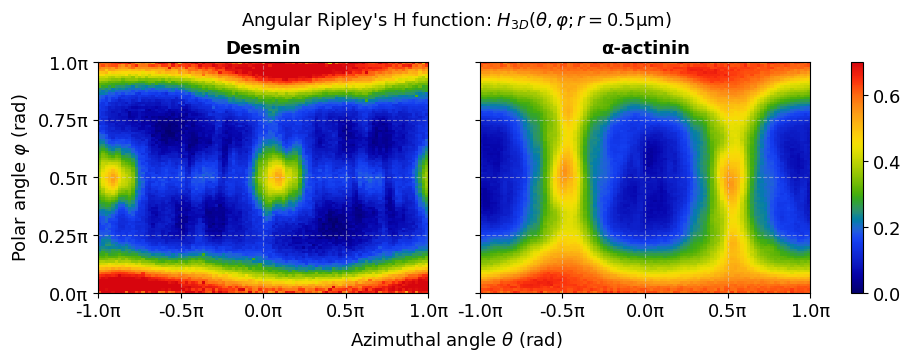

In [ ]:
import colorcet as cc


fig, axes = plt.subplots(
    1, 2, figsize=(9, 3.5), sharey=True, sharex=True, constrained_layout=True
)
for ax, protein in zip(axes, ("desmin", "actinin")):
    mesh = ax.pcolormesh(
        *bins,
        np.mean(ripley_H_3d[protein], axis=0).T,
        cmap=cc.cm.rainbow4,
        vmin=0,
        vmax=0.7,
        antialiased=True,
    )
    ax.set_xticks(
        [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
        ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
    )
    ax.set_yticks(
        [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
        ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
    )

    fig.supxlabel("Azimuthal angle " + r"$\theta$" + " (rad)", fontsize="medium")
    axes[0].set_ylabel("Polar angle " + r"$\varphi$" + " (rad)", fontsize="medium")
    ax.grid(ls="--", color="lightgray", alpha=0.5)

    ax.set_title(
        LABEL_DICT[protein],
        # color=COLOR_DICT[protein],
        fontsize="medium",
        fontweight="semibold",
    )
fig.colorbar(
    mesh,
    ax=axes.ravel().tolist(),
    pad=0.03,
)

fig.suptitle(
    "Angular Ripley's H function: " + r"$H_{3D}(\theta, \varphi; r=0.5\text{μm})$",
    fontsize="medium",
)
# fig.savefig("../figures/fig_3/3b/angular_ripley_3d.svg", dpi=500)

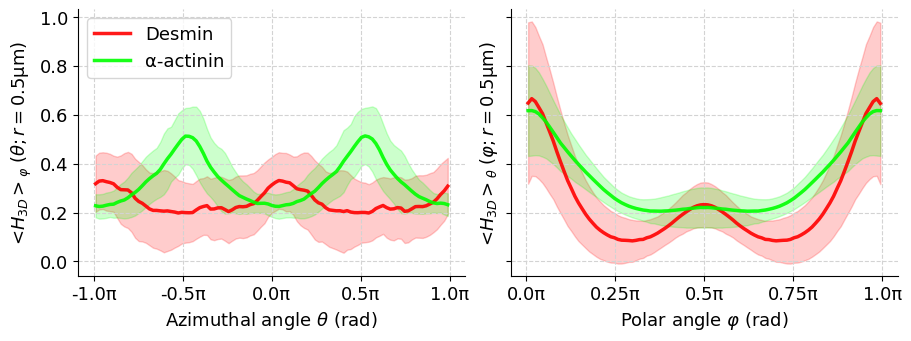

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.3), constrained_layout=True, sharey=True)
for i, ax in enumerate(axes):
    for protein in ("desmin", "actinin"):
        h_3d_proj = np.mean(ripley_H_3d[protein], axis=-(i + 1))
        ax = line_and_bandplot(
            ax,
            bin_centers[i],
            np.mean(h_3d_proj, axis=0),
            np.std(h_3d_proj, axis=0),
            color=COLOR_DICT[protein],
            label=LABEL_DICT[protein],
            linewidth=2.5,
            alpha=0.9,
            alpha_band=0.2,
        )
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(ls="--", color="lightgray")
axes[0].set_xticks(
    [-np.pi, -0.5 * np.pi, 0, 0.5 * np.pi, np.pi],
    ["-1.0π", "-0.5π", "0.0π", "0.5π", "1.0π"],
)
axes[0].set_xlabel("Azimuthal angle " + r"$\theta$" + " (rad)")
axes[1].set_xticks(
    [0, 0.25 * np.pi, 0.5 * np.pi, 0.75 * np.pi, np.pi],
    ["0.0π", "0.25π", "0.5π", "0.75π", "1.0π"],
)
axes[1].set_xlabel("Polar angle " + r"$\varphi$" + " (rad)")
axes[0].set_ylabel(r"<$H_{3D}>_{\varphi}\;(\theta; r=0.5\text{μm})$", fontsize="medium")
axes[1].set_ylabel(r"<$H_{3D}>_{\theta}\;(\varphi; r=0.5\text{μm})$", fontsize="medium")
axes[0].legend(loc="upper left")

fig.savefig("../figures/fig_3/3b/angular_ripley_3d_projections.svg", dpi=500)